In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import scipy
import argparse
import plotly.graph_objects as go
import pgeocode
import plotly.express as px
from IPython.display import Image
import kaleido

# Image processing
import cv2
import imageio
import skimage
import skimage.io
import skimage.transform
from skimage.color import rgb2gray

# Tensorflow
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow


#Sklearn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN as dbs
from sklearn.model_selection import GridSearchCV

RSEED=42
bee_imgs = "data/bee_imgs/bee_imgs/"
sns.set(font='sans-serif', font_scale=1)

In [3]:
bee_data = pd.read_csv('data/bee_data.csv',
                       parse_dates={'datetime': [1, 2]},
                       dtype={'subspecies': 'category','health': 'category','caste': 'category'})

In [4]:
bee_data.head()

datetime         file        location  zip code subspecies  \
0 2018-08-28 16:07:00  041_066.png  Alvin, TX, USA     77511         -1   
1 2018-08-28 16:07:00  041_072.png  Alvin, TX, USA     77511         -1   
2 2018-08-28 16:07:00  041_073.png  Alvin, TX, USA     77511         -1   
3 2018-08-28 16:07:00  041_067.png  Alvin, TX, USA     77511         -1   
4 2018-08-28 16:07:00  041_059.png  Alvin, TX, USA     77511         -1   

              health  pollen_carrying   caste  
0  hive being robbed            False  worker  
1  hive being robbed            False  worker  
2  hive being robbed            False  worker  
3  hive being robbed            False  worker  
4  hive being robbed            False  worker

In [5]:
bee_data.columns = bee_data.columns.str.replace(' ', '_')

In [6]:
bee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         5172 non-null   datetime64[ns]
 1   file             5172 non-null   object        
 2   location         5172 non-null   object        
 3   zip_code         5172 non-null   int64         
 4   subspecies       5172 non-null   category      
 5   health           5172 non-null   category      
 6   pollen_carrying  5172 non-null   bool          
 7   caste            5172 non-null   category      
dtypes: bool(1), category(3), datetime64[ns](1), int64(1), object(2)
memory usage: 182.5+ KB


In [7]:
bee_data.describe()

zip_code
count   5172.000000
mean   68599.910480
std    27101.954146
min     3431.000000
25%    50315.000000
50%    77511.000000
75%    95070.000000
max    95124.000000

In [8]:
from chart_studio import plotly

In [9]:
bee_data_health = bee_data.health.value_counts()
fig = px.bar(bee_data_health, y='health',
             hover_data=['health'], color='health',
             labels={'health':'Number of Images', 'index': 'Health Status'}, height=400)
fig.show()
# plotly.io.write_image(fig, 'fig1.png', format='png',validate=False, engine='kaleido')
# fig.write_image("plots/fig1.png")
# Image("plots/fig1.png")

In [10]:
bee_data_sub = bee_data.subspecies.value_counts()
fig = px.bar(bee_data_sub, y='subspecies',
             hover_data=['subspecies'], color='subspecies',
             labels={'subspecies':'Number of Images', 'index': 'Subspecies'}, height=400)
fig.show()
# fig.write_image("plots/fig2.png")
# Image("plots/fig2.png")

In [11]:
bee_data_caste = bee_data.caste.value_counts()
fig = px.bar(bee_data_caste, y='caste',
             hover_data=['caste'],
             labels={'caste':'Number of Images', 'index': 'Caste'}, height=400)
fig.show()
# fig.write_image("plots/fig3.png")
# Image("plots/fig3.png")

In [12]:
bee_data_pollen = bee_data.pollen_carrying.value_counts()
fig = px.bar(bee_data_pollen, y='pollen_carrying',
             hover_data=['pollen_carrying'],
             labels={'pollen_carrying':'Number of Images', 'index': 'Pollen Carrying'}, height=400)
fig.show()
# fig.write_image("plots/fig4.png")
# Image("plots/fig4.png")

In [13]:
bee_data_dum = bee_data.copy()

In [14]:
subspecies_dummies = pd.get_dummies(bee_data_dum.subspecies, drop_first=True)

In [15]:
subspecies_dummies.columns = subspecies_dummies.columns.str.replace(' ', '_')

In [16]:
pollen_dummies = pd.get_dummies(bee_data_dum.pollen_carrying, drop_first=True, prefix = 'pollen_')

In [17]:
health_dummies = pd.get_dummies(bee_data_dum.health, drop_first=True)

In [18]:
health_dummies.columns = health_dummies.columns.str.replace(' ', '_')

In [19]:
health_dummies.missing_queen.value_counts()

0    5143
1      29
Name: missing_queen, dtype: int64

In [20]:
health_dummies.hive_being_robbed.value_counts()

0    4921
1     251
Name: hive_being_robbed, dtype: int64

In [21]:
location_dummies = pd.get_dummies(bee_data_dum.location, drop_first=True)

In [22]:
location_dummies.columns = location_dummies.columns.str.replace(' ', '_')

In [23]:
zip_dummies = pd.get_dummies(bee_data_dum.zip_code, drop_first=True)

In [24]:
caste_dummies = pd.get_dummies(bee_data_dum.caste)

In [25]:
drop_columns = [
    'health', 'subspecies', 'pollen_carrying', 'caste', 'location', 'zip_code'
]
bee_data_dum.drop(drop_columns, axis=1, inplace=True)

In [26]:
bee_data_dum = pd.concat([
    bee_data_dum, health_dummies, pollen_dummies, subspecies_dummies,
    caste_dummies, zip_dummies, location_dummies
],
                         axis=1)
bee_data_dum.head()

datetime         file  ant_problems  few_varrao,_hive_beetles  \
0 2018-08-28 16:07:00  041_066.png             0                         0   
1 2018-08-28 16:07:00  041_072.png             0                         0   
2 2018-08-28 16:07:00  041_073.png             0                         0   
3 2018-08-28 16:07:00  041_067.png             0                         0   
4 2018-08-28 16:07:00  041_059.png             0                         0   

   healthy  hive_being_robbed  missing_queen  pollen__True  \
0        0                  1              0             0   
1        0                  1              0             0   
2        0                  1              0             0   
3        0                  1              0             0   
4        0                  1              0             0   

   1_Mixed_local_stock_2  Carniolan_honey_bee  ...  77511  95070  95124  \
0                      0                    0  ...      1      0      0   
1                      0                    0  ...      1      0      0   
2                      0                    0  ...      1      0      0   
3                      0                    0  ...      1      0      0   
4                      0                    0  ...      1      0      0   

   Athens,_GA,_USA  Athens,_Georgia,_USA  Des_Moines,_IA,_USA  Keene,_NH,_USA  \
0                0                     0                    0               0   
1                0                     0                    0               0   
2                0                     0                    0               0   
3                0                     0                    0               0   
4                0                     0                    0               0   

   New_Orleans,_LA,_USA  San_Jose,_CA,_USA  Saratoga,_CA,_USA  
0                     0                  0                  0  
1                     0                  0                  0  
2                     0                  0                  0  
3                     0                  0                  0  
4                     0                  0                  0  

[5 rows x 28 columns]

In [27]:
matrix = np.triu(bee_data_dum.corr())

In [28]:
idx_lst = []
zip_lst = []
zip_data = pgeocode.Nominatim('us')
for idx, zip in bee_data.zip_code.iteritems():
    idx_lst.append(idx)
    zip_lst.append(str(zip))
zip_data = zip_data.query_postal_code(zip_lst)

In [29]:
zip_data.drop(['county_code', 'community_name', 'community_code', 'accuracy'],axis=1, inplace=True)

In [30]:
zip_data.columns = zip_data.columns.str.replace(' ', '_')

In [31]:
bee_data.drop(['location', 'zip_code'], axis=1, inplace=True)

In [32]:
bee_data = pd.concat([
    bee_data, zip_data
],axis=1)

In [33]:
bee_data.health.unique()

['hive being robbed', 'healthy', 'few varrao, hive beetles', 'ant problems', 'missing queen', 'Varroa, Small Hive Beetles']
Categories (6, object): ['Varroa, Small Hive Beetles', 'ant problems', 'few varrao, hive beetles', 'healthy', 'hive being robbed', 'missing queen']

In [34]:
new_cat = {
    'few varrao, hive beetles': 'varroa and hive beetles',
    'Varroa, Small Hive Beetles': 'varroa and hive beetles'
}

bee_data.health.replace(new_cat, inplace=True)

In [35]:
bee_data.health.dropna(inplace=True)

In [36]:
bee_data.health.astype('category').dtype

CategoricalDtype(categories=['ant problems', 'varroa and hive beetles', 'healthy',
                  'hive being robbed', 'missing queen'],
, ordered=False)

In [37]:
index_num = bee_data[bee_data['health'] == 'missing queen'].index

In [38]:
bee_data.drop(index_num , inplace=True)

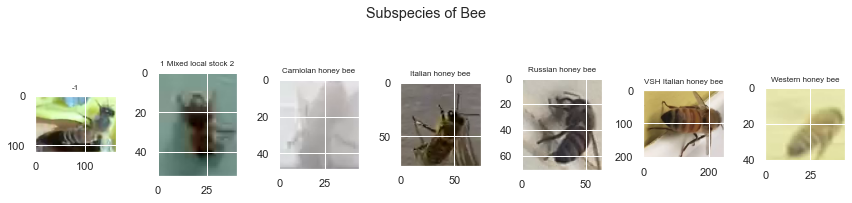

In [39]:
subspecies = bee_data['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1, ncols=subspecies.size, figsize=(12, 3))
i = 0
for s in subspecies:
    if s == 'healthy':
        continue
    file = bee_imgs + bee_data[bee_data['subspecies'] == s].iloc[0]['file']
    im = imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i += 1

plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

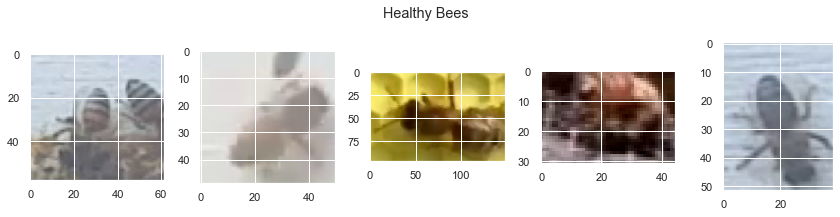

In [40]:
n = 5
healthy = bee_data[bee_data['health'] == 'healthy'].sample(n)

f, ax = plt.subplots(nrows=1, ncols=n, figsize=(12, 3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0, 5):
    file = bee_imgs + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

In [41]:
health_cats = set()
for d in bee_data.health:
    health_cats.add(d)

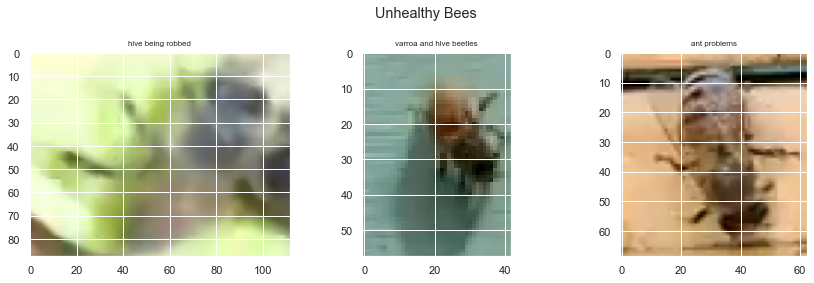

In [42]:
f, ax = plt.subplots(1, len(health_cats) - 1, figsize=(12, 4))
i = 0
for c in health_cats:
    if c == 'healthy':
        continue
    bee_img = bee_data[bee_data['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(bee_imgs + bee_img['file']))
    ax[i].set_title(bee_img['health'], fontsize=8)
    i += 1

plt.suptitle("Unhealthy Bees")
plt.tight_layout()
plt.show()

In [43]:
def resize_img(file):
    """
    Read and resize img, adjust channels.
    """
    img = skimage.io.imread(bee_imgs + file)
    img = skimage.transform.resize(img, (100, 100), mode='reflect')
    img = rgb2gray(img[:, :, :3])
    img = img.flatten()
    return img

In [44]:
train_bee, test_bee = train_test_split(bee_data, random_state=RSEED)

X_train = np.stack(train_bee['file'].apply(resize_img)) 
y_train  = train_bee['health']
y_test  = test_bee['health']
X_test = np.stack(test_bee['file'].apply(resize_img))

In [54]:
g = bee_data.copy()
ncat_bal = int(len(bee_data) / len(health_cats))
# g = pd.DataFrame(g.groupby('health', as_index=False).apply(lambda g: g.sample(ncat_bal, replace=True)).reset_index(drop=True))

def sample(df, state, frac, replace):
    rs = np.random.RandomState(state)
    return df.sample(random_state=rs, frac=frac, replace=replace)

# i.e. return df.sample(random_state=rs, frac=frac, replace=replace) \
#             if len(df) > 0 else df
# g.health.value_counts()

In [55]:
data = []
categories = []
# loop over the image paths
for idx in g.index:
    cat = g.health[idx]
    image = cv2.imread(bee_imgs + g.file[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image/255


    data.append(image)
    categories.append(cat)

In [56]:
# convert the data and labels to NumPy arrays
data = np.array(data)
categories = np.array(categories)
lb = LabelBinarizer()
categories = lb.fit_transform(categories)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, categories,
    test_size=0.25, stratify=categories, random_state=RSEED)

In [57]:
(X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn) = train_test_split(X_train, y_train,
    test_size=0.15, random_state=RSEED)

In [58]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object
valAug = ImageDataGenerator()

In [59]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(128, 128 ,3)),
    MaxPooling2D(2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(2),
    Conv2D(64, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [61]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [62]:
training = model.fit(trainAug.flow(X_train_cnn,y_train_cnn, batch_size=64),
                        epochs=15,
                        steps_per_epoch=40,
                        validation_data=valAug.flow(X_val_cnn, y_val_cnn),
                        callbacks = [early_stop]
         )

Epoch 1/15
40/40 [==============================] - 44s 1s/step - loss: 1.5751 - accuracy: 0.6247 - val_loss: 0.8044 - val_accuracy: 0.6891
Epoch 2/15
40/40 [==============================] - 35s 877ms/step - loss: 0.5970 - accuracy: 0.7733 - val_loss: 0.3346 - val_accuracy: 0.8826
Epoch 3/15
40/40 [==============================] - 36s 889ms/step - loss: 0.3435 - accuracy: 0.8749 - val_loss: 0.2406 - val_accuracy: 0.9292
Epoch 4/15
40/40 [==============================] - 35s 859ms/step - loss: 0.4618 - accuracy: 0.8474 - val_loss: 0.4753 - val_accuracy: 0.8549
Epoch 5/15
40/40 [==============================] - 34s 854ms/step - loss: 0.3163 - accuracy: 0.8876 - val_loss: 0.1571 - val_accuracy: 0.9430
Epoch 6/15
40/40 [==============================] - 34s 856ms/step - loss: 0.1806 - accuracy: 0.9394 - val_loss: 0.1463 - val_accuracy: 0.9551
Epoch 7/15
40/40 [==============================] - 34s 852ms/step - loss: 0.1338 - accuracy: 0.9534 - val_loss: 0.1274 - val_accuracy: 0.9706
Ep

In [63]:
y_pred_cnn = model.predict(X_test)

In [64]:
def visualize_layer_kernels(img, conv_layer, title):
    """
    Displays how input sample image looks after convolution by each kernel.
    """
    # Extract kernels from given layer
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]

    # Each row contains 3 images: kernel, input image, output image
    f, ax = plt.subplots(kernels_num, 3, figsize=(7, kernels_num * 2))

    for i in range(0, kernels_num):
        # Get kernel from the layer and draw it
        kernel = kernels[:, :, :3, i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize=9)

        # Get and draw sample image from test data
        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)

        # Filtered image - apply convolution
        img_filt = scipy.ndimage.filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)

    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

C:\Users\nisha\AppData\Local\Temp\ipykernel_1312\640214011.py:24: DeprecationWarning:

Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.



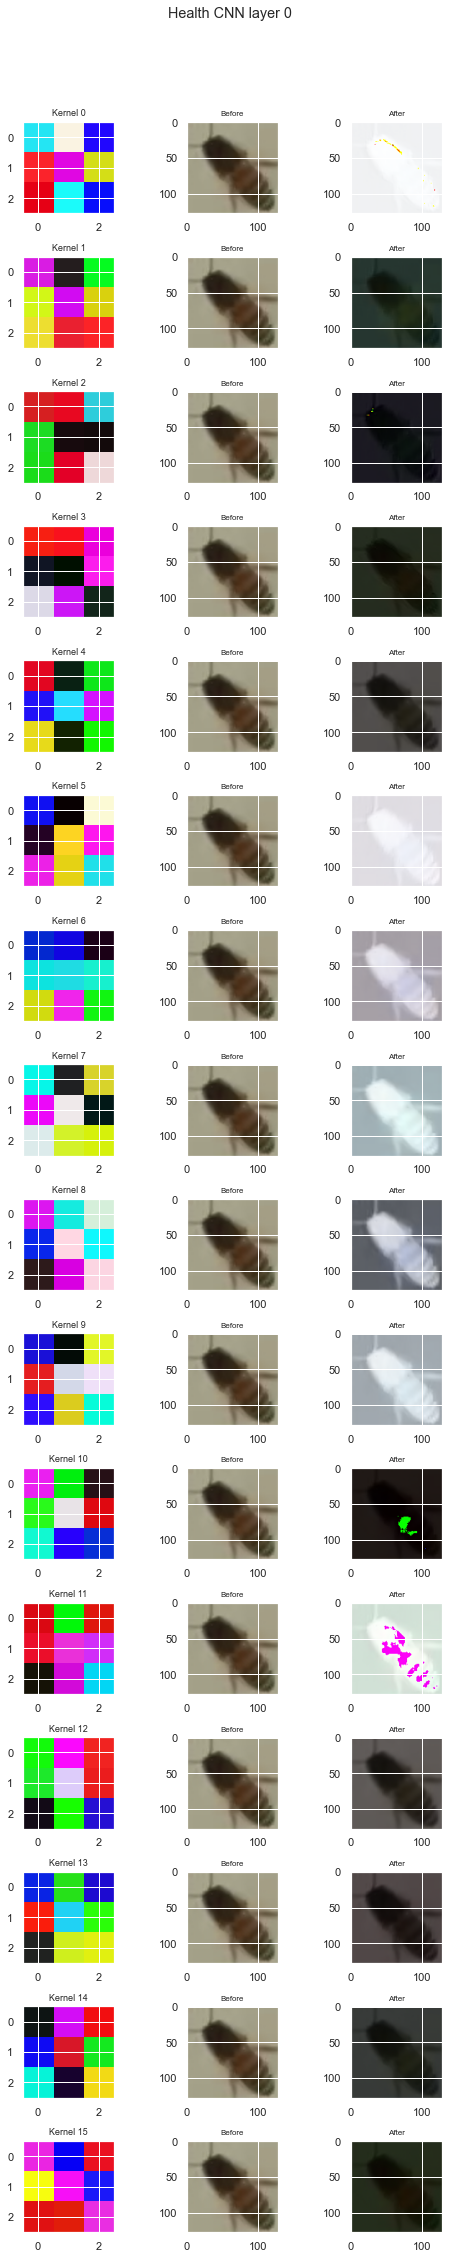

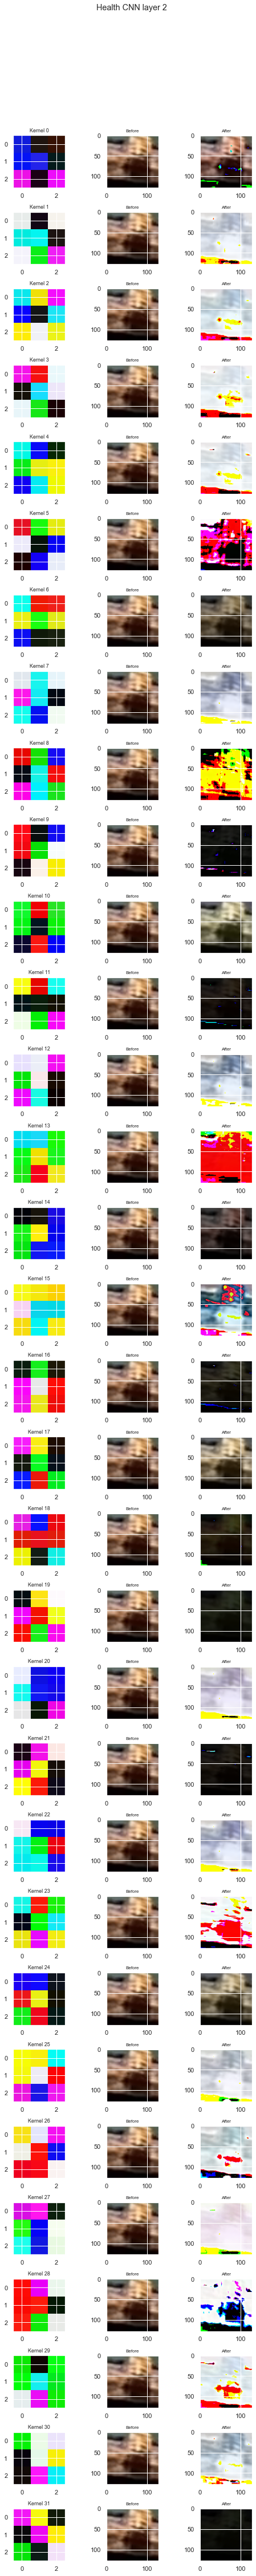

In [65]:
# Take sample image to visualize convolution
idx = random.randint(0,len(X_test)-1)
img = X_test[idx,:,:,:]
#img = img[:,:,:]
# Take 1st convolutional layer and look at it's filters
conv1 = model.layers[0]
visualize_layer_kernels(img, conv1, "Health CNN layer 0")

# Take sample image to visualize convolutoin
idx = random.randint(0,len(X_test)-1)
img = X_test[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv2 = model.layers[2]
visualize_layer_kernels(img, conv2, "Health CNN layer 2")

In [66]:
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    @param training: model training history
    @param model: trained model
    @param test_X: features 
    @param test_y: labels
    @param field_name: label name to display on plots
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Accuracy
    ax[1].plot(training.history['accuracy'], label="Accuracy")
    ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)

    #acc_by_subspecies = np.logical_and(
    #    (test_pred > 0.5), test_y).sum() / test_y.sum()
    #acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    #plt.ylabel('Accuracy')
    #plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y, axis=1)
    print(
        metrics.classification_report(test_truth,
                                      test_pred,
                                      target_names=health_cats))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

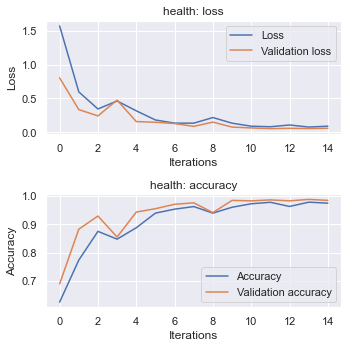

Classification report
                         precision    recall  f1-score   support

                healthy       0.97      0.97      0.97       114
      hive being robbed       0.98      0.99      0.99       846
varroa and hive beetles       0.89      0.75      0.81        63
           ant problems       0.96      0.98      0.97       263

               accuracy                           0.97      1286
              macro avg       0.95      0.92      0.93      1286
           weighted avg       0.97      0.97      0.97      1286

Loss function: 0.09791933000087738, accuracy: 0.9727838039398193


In [67]:
eval_model(training, model, X_test, y_test, 'health')

In [68]:
y_pred = model.predict(X_test)
test_truth = np.argmax(y_test, axis=1)
y_pred_final = np.argmax(y_pred, axis=1)
right_cnn = y_pred_final == test_truth
health_cats

{'ant problems', 'healthy', 'hive being robbed', 'varroa and hive beetles'}

In [69]:
classes_dic = {
    0: "Ant Problem",
    1: 'Healthy',
    2: 'Hive Beeing Robbed',
    3: 'Varroa Mites or Hive Beetles'
}

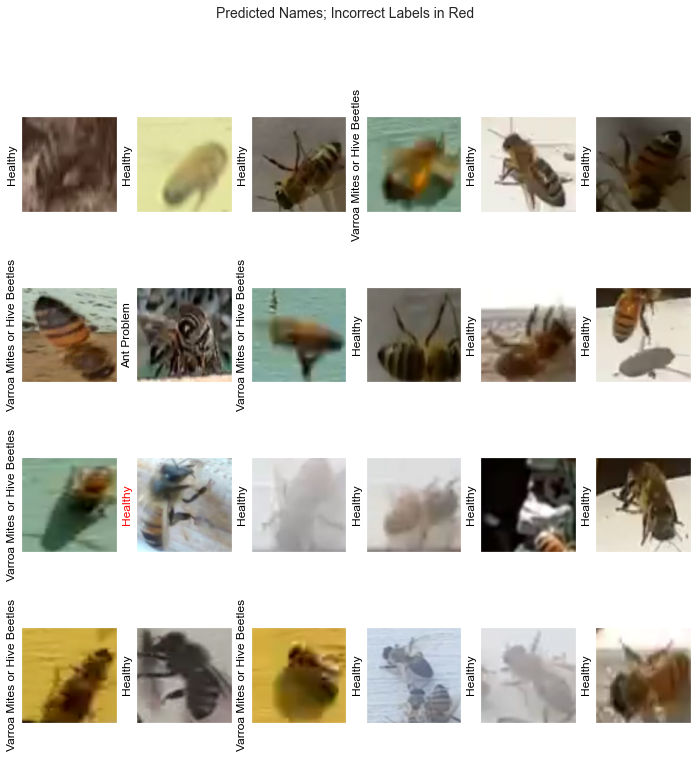

In [70]:
fig, ax = plt.subplots(4, 6, figsize=(12, 12))
counter = 0
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(classes_dic[y_pred_final[i]],
                   color='black' if right_cnn[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);